In [1]:
# Import packages
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import matplotlib.pyplot as plt
import scarlet
import pickle

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord

#plt.rcParams['font.size'] = 15
#plt.rc('image', cmap='inferno', interpolation='none', origin='lower')


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

### Make one figure containing all useful information

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [4]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1013.fits')
lsbg_cat.sort('viz-id')

In [54]:
lsbg = lsbg_cat[int(np.where(lsbg_cat['viz-id'] == 19181)[0][0])]

In [52]:
lsbg['viz-id']

18410

### Run scarlet modeling

In [29]:
from kuaizi.fitting import fitting_wavelet_obs_tigress, _fitting_wavelet

In [15]:
# scarlet_flag
# 0: not processed
# 1: no bug
# -1: problematic
# lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [39]:
fail_logger = kz.utils.set_logger(logger_name='nsa_test_fail', file_name='nsa_fail', level='ERROR')
global_logger = kz.utils.set_logger(logger_name='nsa_test', file_name='nsa_log', level='INFO')

### Running scarlet wavelet modeling for `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_19181`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    5 stars from Gaia are masked!
    Detected 259 objects
    5 stars from Gaia are masked!
    Detected 241 objects
    Detected 95 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = 0.10, starlet_thresh = 0.50 (contam_ratio = 0.08).
    Total number of sources: 6
    Optimizaiton: Succeed for e_rel = 1e-04 with 5 iterations! Try higher accuracy!
  ! Might be poor fitting! Iterations less than 50.
  - After 38 iterations, logL = 2153737.92
    Elapsed time for fitting: 17.68 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/nsa-19181-trai

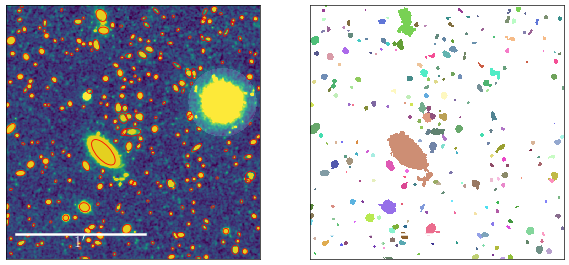

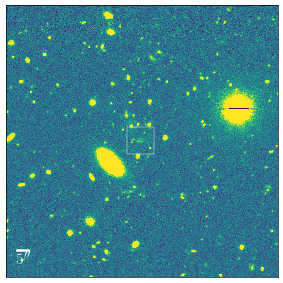

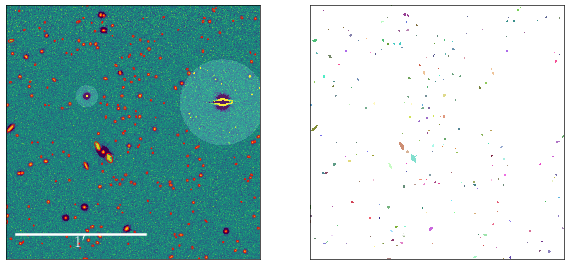

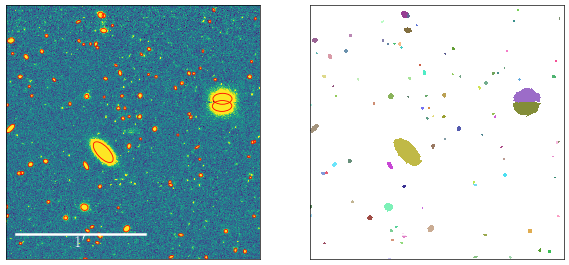

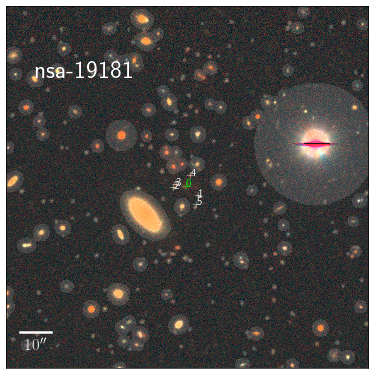

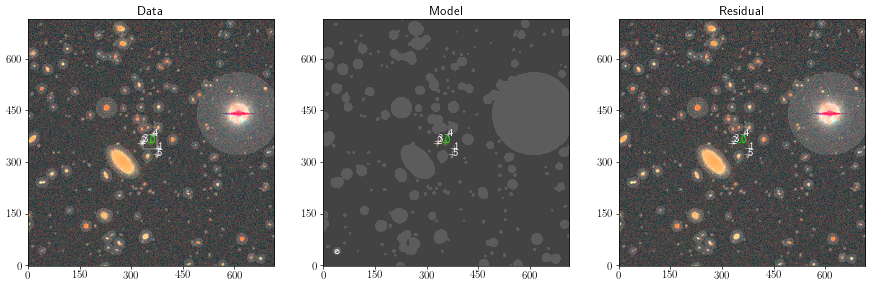

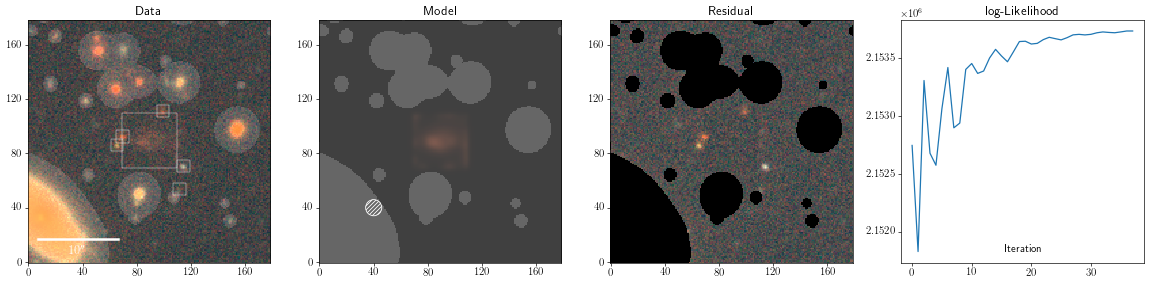

In [55]:
index = 0
blend = fitting_wavelet_obs_tigress(
    {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}, 
    lsbg,
    name='viz-id',
    channels='griz',
    starlet_thresh=0.5,
    prefix='nsa',
    show_figure=True, 
    global_logger=None, # global_logger, 
    fail_logger=None, # fail_logger
)

# if blend: # if succeeded
#     lsbg_cat[index]['scarlet_flag_0.5'] = 1
# else:
#     lsbg_cat[index]['scarlet_flag_0.5'] = -1

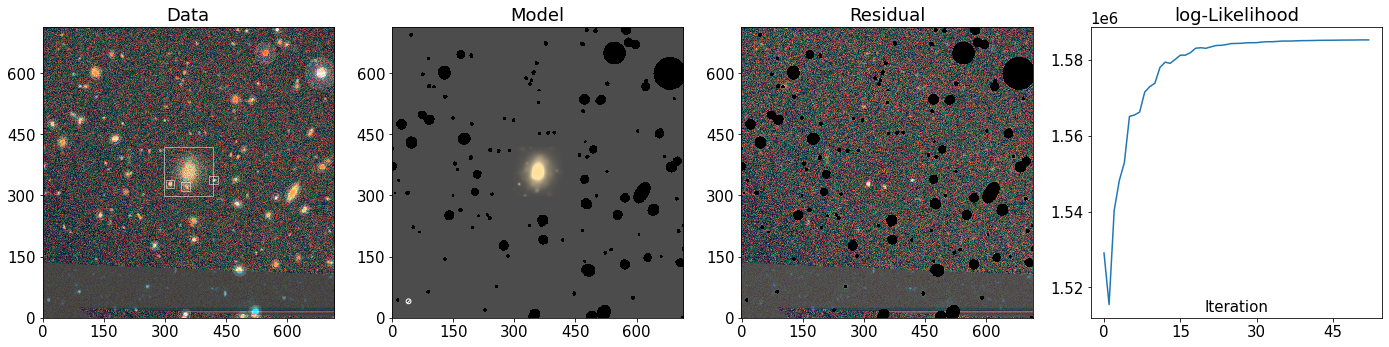

In [97]:
fig = kz.display.display_scarlet_results_tigress(
        blend,
        show_ind=[0],
        #zoomin_size=120,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

#plt.savefig('/tigress/jiaxuanl/public_html/candy/candy-2-zoomin.png', dpi=55, bbox_inches='tight')

## Multiprocessing

In [24]:
suffix = '_test'
fail_logger = kz.utils.set_logger(
    logger_name='candy_fail' + suffix, file_name='candy_fail' + suffix, level='ERROR')
global_logger = kz.utils.set_logger(
    logger_name='candy_sample' + suffix, file_name='candy_log' + suffix, level='INFO')
#lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [25]:
from multiprocessing import Pool, Manager
from functools import partial

In [ ]:
def multiprocess_fitting(index):
    #if not os.path.isfile(f'./Models/LSBG-{lsbg_cat[index]["Seq"]:04d}-trained-model-wavelet.df'): 
    blend = fitting_wavelet_obs_tigress(
        {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tiger/scratch/gpfs/jiaxuanl/Data'}, 
        lsbg_cat[index],
        name='Seq',
        channels='griz',
        starlet_thresh=0.5,
        prefix='candy',
        show_figure=False, 
        global_logger=global_logger,
        fail_logger=fail_logger)
    
print('Number of processor to use:')
n_jobs = 6
manager = Manager()
pool = Pool(n_jobs)

#measurement_cat = manager.dict()
iterable = np.arange(50, 100, 1) # np.random.randint(0, len(lsbg_cat), 50)

#func = partial(fitting_single_comp, s18a)
pool.map(multiprocess_fitting, iterable)
pool.close()
pool.join()